* <font color="red">assignment problem</font>. The red color indicates the task that should be done
* <font color="green">debugging</font>. The green tells you what is expected outcome. Its primarily goal is to help you get the correct answer
* <font color="blue">comments, hints</font>.

Assignment 3 (CNN)
======================


**Useful References:**

* official pytorch cifar10 tutorial

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

* tensorboard & colab

https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks

https://colab.research.google.com/drive/1NbEqqB42VSzYt-mmb4ESc8yxL05U2TIV


## Preliminaries


#### Check the environment

In [67]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [68]:
!nvidia-smi

Wed Dec 30 19:18:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   79C    P0    44W /  N/A |   1715MiB /  8192MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Load libs, set settings

In [69]:
import numpy as np
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# for tensorboard
from torch.utils.tensorboard import SummaryWriter

In [70]:
from tqdm import tqdm_notebook as tqdm

In [71]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

In [72]:
# load the TensorBoard notebook extension
# %load_ext tensorboard

# for auto-reloading external modules (files, etc.)
%load_ext autoreload
%autoreload 2

# to be able to make plots inline the notebook 
# (actually no need for the colab version)
%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define pathes

In [73]:
# path for dataset (will be not there after end of session)
path_data = "../data"

## Data

Using ``torchvision`` load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [74]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 16

trainset = torchvision.datasets.CIFAR10(root=path_data, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root=path_data, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [75]:
ls data

 Volume in drive C has no label.
 Volume Serial Number is 1EB9-42ED

 Directory of c:\Users\dkushn\Documents\GitHub\KushnirDmytro-ucuCV2020_HW6\notebooks

File Not Found


Let us show some of the training images, just for fun.



     horse     plane     car       plane    


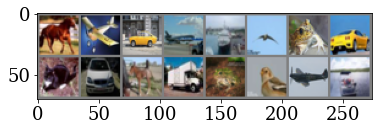

In [76]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('     ' + ' '.join('{:9}'.format(classes[labels[j]]) for j in range(4)))

## Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function

Let's use a Classification Cross-Entropy loss



In [78]:
criterion = nn.CrossEntropyLoss()

## Set-up training




In [79]:
def train_epoch(train_loader, model, criterion, optimizer, scheduler, 
                epoch, device, log_interval, globaliter, desc="<no description>"):

    # switch to train mode
    model.train()

    running_loss = 0.0
    tk0 = tqdm(train_loader, desc=desc, unit_scale=train_loader.batch_size)

    for batch_idx, (input_data, target) in enumerate(tk0):
      
        # TODO: do in other way (this is global batch index, for logging)
        globaliter += 1
      
        # extract batch data
        target = target.to(device)
        input_data = input_data.to(device)

        # compute output
        output = model(input_data)
        loss = criterion(output, target)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item() * input_data.size(0)

        # logging
        if batch_idx % log_interval == 0:

            running_loss_avg = running_loss / ((batch_idx+1) * train_loader.batch_size)
            tk0.set_postfix(loss=running_loss_avg)
        
            if (batch_idx > 5):
                # log loss
                writer.add_scalar('Train/RunningLoss', running_loss_avg, globaliter)
            # log LR
            lr = scheduler.get_last_lr()[0]
            writer.add_scalar('Train/LearningRate', lr, globaliter)
    
    # adjust_learning_rate
    if scheduler is not None:
        scheduler.step()

    return globaliter, running_loss

## Logging

In [80]:
def initWriter(experiment_name = "e_x"):
    # path for TensorBoard log file (will be not there after end of session)
    current_time = datetime.datetime.now().strftime("_%d-%m-%Y_%H-%M-%S")

    path_log = 'logs/tensorboard/' + experiment_name + current_time

    # set-up TensorBoard writer
    writer = SummaryWriter(path_log)
    
    print("initialized log " + path_log)
    return writer

In [81]:
# # images to TensorBoard
# images, labels = next(iter(trainloader))
# grid = torchvision.utils.make_grid(images)
# writer.add_image('images', grid, 0)

# # net to TensorBoard
# writer.add_graph(net, images)

## Eval routines

In [82]:
def eval_model(data_loader, model, desc = "Eval"):
    model.cpu()  # eval is not resourse consuming, still fast on cpu
    model.eval()
    correct = 0
    total = 0

    accuracy = 0
    tk0 = tqdm(data_loader, desc=desc, unit_scale=data_loader.batch_size)
    with torch.no_grad():
        for data in tk0:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total

    return accuracy

In [83]:
def eval_model_epoch(test_loader, train_loader, writer, model, epoch):
    test_accuracy = eval_model(test_loader, model, "Eval test. Ep:" + str(epoch))
    train_accuracy = eval_model(train_loader, model, "Eval train. Ep:" + str(epoch))
    print("Ep: {} test accuracy: {}".format(epoch, test_accuracy))
    print("Ep: {} train accuracy: {}".format(epoch, train_accuracy))
    writer.add_scalars(f'Ep.Accuracy/check_info', { 'test': test_accuracy, 'train': train_accuracy }, epoch)

## Training procedure

In [84]:
(len(trainloader) * trainloader.batch_size)

50000

In [85]:
# Don't forget to reset logger
writer = initWriter("e0005_bs16")

# set number of epoch
n_epochs = 5

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=1000,
                                            gamma=0.1)

eval_model_epoch(test_loader = testloader, train_loader = trainloader, writer = writer, model=net, epoch=0)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    
    globaliter, running_loss = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, 'cpu', 500, globaliter, "Training. Ep: " + str(epoch))

    epoch_loss = running_loss / (len(trainloader) * trainloader.batch_size)
    print('Ep: {} Training Loss: {:.4f}'.format(epoch, epoch_loss))
    writer.add_scalar('Train.Epoch/Loss', epoch_loss, epoch)

    lr = scheduler.get_last_lr()[0]
    writer.add_scalar('Train.Epoch/LearningRate', lr, epoch)
    
    eval_model_epoch(test_loader = testloader, train_loader = trainloader, writer = writer, model=net, epoch=epoch)

initialized log logs/tensorboard/e0005_bs16_30-12-2020_19-18-16


Eval test. Ep:0:   0%|          | 0/10000 [00:00<?, ?it/s]

Eval train. Ep:0:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 0 test accuracy: 9.25
Ep: 0 train accuracy: 9.272


Training. Ep: 1:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 1 Training Loss: 2.0387


Eval test. Ep:1:   0%|          | 0/10000 [00:00<?, ?it/s]

Eval train. Ep:1:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 1 test accuracy: 35.33
Ep: 1 train accuracy: 35.338


Training. Ep: 2:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 2 Training Loss: 1.5899


Eval test. Ep:2:   0%|          | 0/10000 [00:00<?, ?it/s]

Eval train. Ep:2:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 2 test accuracy: 44.31
Ep: 2 train accuracy: 44.464


Training. Ep: 3:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 3 Training Loss: 1.4210


Eval test. Ep:3:   0%|          | 0/10000 [00:00<?, ?it/s]

Eval train. Ep:3:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 3 test accuracy: 51.46
Ep: 3 train accuracy: 52.592


Training. Ep: 4:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 4 Training Loss: 1.3051


Eval test. Ep:4:   0%|          | 0/10000 [00:00<?, ?it/s]

Eval train. Ep:4:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 4 test accuracy: 54.63
Ep: 4 train accuracy: 55.7


Training. Ep: 5:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 5 Training Loss: 1.2166


Eval test. Ep:5:   0%|          | 0/10000 [00:00<?, ?it/s]

Eval train. Ep:5:   0%|          | 0/50000 [00:00<?, ?it/s]

Ep: 5 test accuracy: 57.06
Ep: 5 train accuracy: 58.982


In [86]:
# check existing, stored log-data
!dir "logs/tensorboard"

 Volume in drive C has no label.
 Volume Serial Number is 1EB9-42ED

 Directory of c:\Users\dkushn\Documents\GitHub\KushnirDmytro-ucuCV2020_HW6\notebooks\logs\tensorboard

30.12.2020  19:18    <DIR>          .
30.12.2020  19:18    <DIR>          ..
30.12.2020  18:52    <DIR>          e0004_30-12-2020_18-04-23
30.12.2020  18:52    <DIR>          e0004_30-12-2020_18-16-31
30.12.2020  18:53    <DIR>          e0004_30-12-2020_18-26-10
30.12.2020  18:53    <DIR>          e0004_30-12-2020_18-30-09
30.12.2020  18:53    <DIR>          e0004_30-12-2020_18-39-22
30.12.2020  18:53    <DIR>          e0004_30-12-2020_18-41-41
30.12.2020  18:53    <DIR>          e0004_30-12-2020_18-45-12
30.12.2020  18:54    <DIR>          e0005_30-12-2020_18-54-17
30.12.2020  19:06    <DIR>          e0005_30-12-2020_19-06-01
30.12.2020  19:14    <DIR>          e0005_30-12-2020_19-14-12
30.12.2020  19:18    <DIR>          e0005_bs16_30-12-2020_19-18-16
               0 File(s)              0 bytes
              13 D

##  Evaluate the network on the test data





* Ground Truth:

     cat       ship      ship      plane    


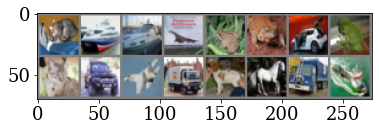

In [87]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('* Ground Truth:')
print()
print('     ' + ' '.join('{:9}'.format(classes[labels[j]]) for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [88]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('* Predicted:')
print()
print('     ' + ' '.join('{:9}'.format(classes[predicted[j]]) for j in range(4)))


* Predicted:

     cat       ship      ship      plane    




Let us look at how the network performs on the whole dataset.



the classes that performed well, and the classes that did
not perform well:



In [89]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of {:5} : {} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66.96035242290749 %
Accuracy of car   : 65.58704453441295 %
Accuracy of bird  : 39.92805755395683 %
Accuracy of cat   : 40.0 %
Accuracy of deer  : 35.18518518518518 %
Accuracy of dog   : 48.333333333333336 %
Accuracy of frog  : 68.42105263157895 %
Accuracy of horse : 56.97674418604651 %
Accuracy of ship  : 76.51821862348179 %
Accuracy of truck : 76.92307692307692 %


## Tasks

<font color="red"> **MORE Tensorboard**: </font>   
- create separate plots with 'epoch vs. loss' (in addition to the current 'interation vs. loss')
- create separate plots with 'epoch vs. accuracy(train)' 
- create separate plots with 'epoch vs. accuracy(test)'
(for this create separate tag 'Test')

<font color="red"> **IMPROVE THE MODEL**: </font>   

Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:
(tips based on 'cs231n course')

*Things to try*:

- Filter size
- Number of filters
- Batch normalization
- Network architecture. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [FC]xM 
    - [conv-relu-pool]XN - [FC]XM 
    - [conv-relu-conv-relu-pool]xN - [FC]xM 
- Some new fancy layers (Lambda-Layer, ...)

*Some tips for training*

For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

*Going above and beyond*

If you are feeling adventurous there are many other features you can implement to try and improve your performance. 

- Alternative update steps:  SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation


*What to expect*

At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! 


<font color="red"> **CPU vs GPU**: </font>   
compare time of training for CPU, GPU for different models

